In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from time import sleep
from IPython.display import clear_output
from math import ceil,floor

%matplotlib inline

# Clase Agente

In [ ]:
class PongAgent:
    
    def __init__(self, game, policy=None, discount_factor = 0.1, learning_rate = 0.1, ratio_explotacion = 0.9):

        # Creamos la tabla de politicas
        if policy is not None:
            self._q_table = policy
        else:
            position = list(game.positions_space.shape)
            position.append(len(game.action_space))
            self._q_table = np.zeros(position)
        
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.ratio_explotacion = ratio_explotacion

    def get_next_step(self, state, game):
        
        # Damos un paso aleatorio...
        next_step = np.random.choice(list(game.action_space))
        
        # o tomaremos el mejor paso...
        if np.random.uniform() <= self.ratio_explotacion:
            # tomar el maximo
            idx_action = np.random.choice(np.flatnonzero(
                    self._q_table[state[0],state[1],state[2]] == self._q_table[state[0],state[1],state[2]].max()
                ))
            next_step = list(game.action_space)[idx_action]

        return next_step

    # actualizamos las politicas con las recompensas obtenidas
    def update(self, game, old_state, action_taken, reward_action_taken, new_state, reached_end):
        idx_action_taken =list(game.action_space).index(action_taken)

        actual_q_value_options = self._q_table[old_state[0], old_state[1], old_state[2]]
        actual_q_value = actual_q_value_options[idx_action_taken]

        future_q_value_options = self._q_table[new_state[0], new_state[1], new_state[2]]
        future_max_q_value = reward_action_taken  +  self.discount_factor*future_q_value_options.max()
        if reached_end:
            future_max_q_value = reward_action_taken #maximum reward

        self._q_table[old_state[0], old_state[1], old_state[2], idx_action_taken] = actual_q_value + \
                                              self.learning_rate*(future_max_q_value -actual_q_value)
    
    def print_policy(self):
        for row in np.round(self._q_table,1):
            for column in row:
                print('[', end='')
                for value in column:
                    print(str(value).zfill(5), end=' ')
                print('] ', end='')
            print('')
            
    def get_policy(self):
        return self._q_table

# Clase Environment

In [ ]:
class PongEnvironment:
    
    def __init__(self, max_life=3, height_px = 40, width_px = 50, movimiento_px = 3):
        
        self.action_space = ['Arriba','Abajo']
        
        self._step_penalization = 0
        
        self.state = [0,0,0]
        
        self.total_reward = 0
        
        self.dx = movimiento_px
        self.dy = movimiento_px
        
        filas = ceil(height_px/movimiento_px)
        columnas = ceil(width_px/movimiento_px)
        
        self.positions_space = np.array([[[0 for z in range(columnas)] 
                                                  for y in range(filas)] 
                                                     for x in range(filas)])

        self.lives = max_life
        self.max_life=max_life
        
        self.x = randint(int(width_px/2), width_px) 
        self.y = randint(0, height_px-10)
        
        self.player_alto = int(height_px/4)

        self.player1 = self.player_alto  # posic. inicial del player
        
        self.score = 0
        
        self.width_px = width_px
        self.height_px = height_px
        self.radio = 2.5

    def reset(self):
        self.total_reward = 0
        self.state = [0,0,0]
        self.lives = self.max_life
        self.score = 0
        self.x = randint(int(self.width_px/2), self.width_px) 
        self.y = randint(0, self.height_px-10)
        return self.state

    def step(self, action, animate=False):
        self._apply_action(action, animate)
        done = self.lives <=0 # final
        reward = self.score
        reward += self._step_penalization
        self.total_reward += reward
        return self.state, reward , done

    def _apply_action(self, action, animate=False):
        
        if action == "Arriba":
            self.player1 += abs(self.dy)
        elif action == "Abajo":
            self.player1 -= abs(self.dy)
            
        self.avanza_player()

        self.avanza_frame()

        if animate:
            clear_output(wait=True);
            fig = self.dibujar_frame()
            plt.show()

        self.state = (floor(self.player1/abs(self.dy))-2, floor(self.y/abs(self.dy))-2, floor(self.x/abs(self.dx))-2)
    
    def detectaColision(self, ball_y, player_y):
        if (player_y+self.player_alto >= (ball_y-self.radio)) and (player_y <= (ball_y+self.radio)):
            return True
        else:
            return False
    
    def avanza_player(self):
        if self.player1 + self.player_alto >= self.height_px:
            self.player1 = self.height_px - self.player_alto
        elif self.player1 <= -abs(self.dy):
            self.player1 = -abs(self.dy)

    def avanza_frame(self):
        self.x += self.dx
        self.y += self.dy
        if self.x <= 3 or self.x > self.width_px:
            self.dx = -self.dx
            if self.x <= 3:
                ret = self.detectaColision(self.y, self.player1)

                if ret:
                    self.score = 10
                else:
                    self.score = -10
                    self.lives -= 1
                    if self.lives>0:
                        self.x = randint(int(self.width_px/2), self.width_px)
                        self.y = randint(0, self.height_px-10)
                        self.dx = abs(self.dx)
                        self.dy = abs(self.dy)
        else:
            self.score = 0

        if self.y < 0 or self.y > self.height_px:
            self.dy = -self.dy

    def dibujar_frame(self):
        fig = plt.figure(figsize=(5, 4))
        a1 = plt.gca()
        circle = plt.Circle((self.x, self.y), self.radio, fc='slategray', ec="black")
        a1.set_ylim(-5, self.height_px+5)
        a1.set_xlim(-5, self.width_px+5)

        rectangle = plt.Rectangle((-5, self.player1), 5, self.player_alto, fc='gold', ec="none")
        a1.add_patch(circle);
        a1.add_patch(rectangle)
        #a1.set_yticklabels([]);a1.set_xticklabels([]);
        plt.text(4, self.height_px, "SCORE:"+str(self.total_reward)+"  LIFE:"+str(self.lives), fontsize=12)
        if self.lives <=0:
            plt.text(10, self.height_px-14, "GAME OVER", fontsize=16)
        elif self.total_reward >= 1000:
            plt.text(10, self.height_px-14, "YOU WIN!", fontsize=16)
        return fig

# Juego

In [ ]:
def play(rounds=5000, max_life=3, discount_factor = 0.1, learning_rate = 0.1,
         ratio_explotacion=0.9,learner=None, game=None, animate=False):

    if game is None:
        # si usamos movimiento_px = 5 creamos una tabla de politicas de 8x10
        # si usamos movimiento_px = 3 la tabla sera de 14x17
        game = PongEnvironment(max_life=max_life, movimiento_px = 3)
        
    if learner is None:
        print("Begin new Train!")
        learner = PongAgent(game, discount_factor = discount_factor,learning_rate = learning_rate, ratio_explotacion= ratio_explotacion)

    max_points= -9999
    first_max_reached = 0
    total_rw=0
    steps=[]

    for played_games in range(0, rounds):
        state = game.reset()
        reward, done = None, None
        
        itera=0
        while (done != True) and (itera < 3000 and game.total_reward<=1000):
            old_state = np.array(state)
            next_action = learner.get_next_step(state, game)
            state, reward, done = game.step(next_action, animate=animate)
            if rounds > 1:
                learner.update(game, old_state, next_action, reward, state, done)
            itera+=1
        
        steps.append(itera)
        
        total_rw+=game.total_reward
        if game.total_reward > max_points:
            max_points=game.total_reward
            first_max_reached = played_games
        
        if played_games %500==0 and played_games >1 and not animate:
            print("-- Partidas[", played_games, "] Avg.Puntos[", int(total_rw/played_games),"]  AVG Steps[", int(np.array(steps).mean()), "] Max Score[", max_points,"]")
                
    if played_games>1:
        print('Partidas[',played_games,'] Avg.Puntos[',int(total_rw/played_games),'] Max score[', max_points,'] en partida[',first_max_reached,']')
        
    #learner.print_policy()
    
    return learner, game

In [ ]:
learner, game = play(rounds=5000, discount_factor = 0.2, learning_rate = 0.1, ratio_explotacion=0.85)

Begin new Train!
-- Partidas[ 500 ] Avg.Puntos[ 18 ]  AVG Steps[ 234 ] Max Score[ 130 ]
-- Partidas[ 1000 ] Avg.Puntos[ 23 ]  AVG Steps[ 249 ] Max Score[ 150 ]
-- Partidas[ 1500 ] Avg.Puntos[ 26 ]  AVG Steps[ 259 ] Max Score[ 150 ]
-- Partidas[ 2000 ] Avg.Puntos[ 28 ]  AVG Steps[ 265 ] Max Score[ 180 ]
-- Partidas[ 2500 ] Avg.Puntos[ 31 ]  AVG Steps[ 277 ] Max Score[ 310 ]
-- Partidas[ 3000 ] Avg.Puntos[ 34 ]  AVG Steps[ 287 ] Max Score[ 310 ]
-- Partidas[ 3500 ] Avg.Puntos[ 34 ]  AVG Steps[ 287 ] Max Score[ 310 ]
-- Partidas[ 4000 ] Avg.Puntos[ 35 ]  AVG Steps[ 289 ] Max Score[ 330 ]
-- Partidas[ 4500 ] Avg.Puntos[ 35 ]  AVG Steps[ 291 ] Max Score[ 410 ]
Partidas[ 4999 ] Avg.Puntos[ 36 ] Max score[ 410 ] en partida[ 4487 ]


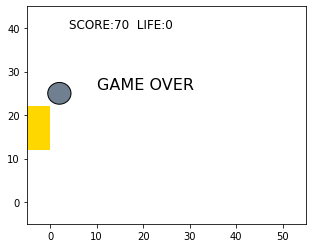

In [ ]:
learner2 = PongAgent(game, policy=learner.get_policy())
learner2.ratio_explotacion = 1.0  # con esto quitamos las elecciones aleatorias al jugar
player = play(rounds=1, learner=learner2, game=game, animate=True)